In [1]:
import mne
from scipy.io import loadmat
import numpy as np

In [2]:
chnames = ['Fp1','Fp2','Fc5','Fz','Fc6','T7','Cz','T8','P7','P3','Pz','P4','P8','O1','Oz','O2','stim']
chtypes = ['eeg'] * 16 + ['stim']
info = mne.create_info(ch_names=chnames, sfreq=512,ch_types=chtypes, montage='standard_1020',verbose=False)
data = loadmat("data/subject_03.mat")["SIGNAL"]

print(data[0])
print(len(data[0]))

[    0.        20976.429688   3298.6860352  4736.3950195 12961.014648
  5785.2348633  5856.0961914 17377.789063     41.0776062 11498.365234
 17605.335938  22601.160156  18115.683594  15631.652344  18219.396484
  9485.4033203 20960.255859      0.            0.       ]
19


In [3]:
import matplotlib.pyplot as plt
for k in range(16):
    plt.plot([d[0] for d in data],[d[k] for d in data])
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
"""
Colonne 1 : timestamp
Colonne 2 à 17 : les données des 16 éléctrodes
Colonne 18 : quand on passe aux yeux sont fermé
Colone 19 : quand on passe aux yeux sont ouvert
filled with zeros, except at the timestamp corresponding to the beginning of
the block for condition 1 (resp. 2), when the row gets a value of one.
"""

'\nColonne 1 : timestamp\nColonne 2 à 17 : les données des 16 éléctrodes\nColonne 18 : quand on passe aux yeux sont fermé\nColone 19 : quand on passe aux yeux sont ouvert\nfilled with zeros, except at the timestamp corresponding to the beginning of\nthe block for condition 1 (resp. 2), when the row gets a value of one.\n'

In [5]:
#On localise les indices des 1
print("0 : Je ferme les yeux")
for k in range(len(data)):
    if(data[k][17]==1):
        print(str(k)+" : J'ouvre les yeux")
    if(data[k][18]==1):
        print(str(k)+" : Je ferme les yeux")

0 : Je ferme les yeux
6685 : J'ouvre les yeux
16288 : Je ferme les yeux
24107 : J'ouvre les yeux
34265 : Je ferme les yeux
42882 : J'ouvre les yeux
50860 : Je ferme les yeux
59039 : J'ouvre les yeux
67072 : Je ferme les yeux
74831 : J'ouvre les yeux
82636 : Je ferme les yeux


In [6]:
#On modifie pour avoir un dataset avec 1 : yeux ouvert et -1 yeux fermée
new_data=[]
yeux_ouvert=False
for k in range(len(data)):
    if(yeux_ouvert==False):
        tmp=np.append(data[k][1:17],-1)
    else:
        tmp=np.append(data[k][1:17],1)
    new_data.append(tmp)
    if(data[k][17]==1):
        yeux_ouvert=True
    if(data[k][18]==1):
        yeux_ouvert=False

In [7]:
print(len(new_data))
print(len(new_data[0]))

91072
17


In [8]:
data = new_data

In [9]:
import pyriemann
from sklearn.model_selection import cross_val_score

In [10]:
labels_train = [d[16] for d in data]
donnees_train = [d[:16] for d in data]

In [26]:
#512 Hz
#On prend 52 trial par échantillon pour avoir un temps de reaction d'environ 0,1015625s
#On supprime les derniers echantillons pour avoir un multiple de 52 et donc des matrices completes
result_acc=[]
tab_trail=[]
for mult in range(2,50):#50
    nb_trail=mult*10#52
    nb_paquet=int(len(donnees_train)/nb_trail)
    donnees_train = donnees_train[:nb_trail*nb_paquet]
    X=np.array(np.split(np.array(donnees_train), nb_paquet))#Ntrial*Nchannels*Nsample
    X=np.swapaxes(X,1,2)
    #estimer la matrice de covariance
    cov = pyriemann.estimation.Covariances().fit_transform(X)
    print("X shape : "+str(X.shape))
    print("cov shape : "+str(cov.shape))

    #validation croisée
    mdm = pyriemann.classification.MDM()
    #mdm =  pyriemann.classification.KNearestNeighbor(n_neighbors=10)
    
    #On modifie les y pour qu'il y est qu'un chiffre tout les 52 enregistrement, on prendra dans un premier temps juste
    #le premier label sur les 52 pour estimer les 52 suivant
    labels_train = labels_train[:nb_trail*nb_paquet]
    yTemp = np.array(np.split(np.array(labels_train), nb_paquet))
    y=np.array([u[0] for u in yTemp])
    print(y.shape)
    accuracy = cross_val_score(mdm, cov , y,cv=5)
    print(accuracy.mean())
    tab_trail.append(nb_trail)
    result_acc.append(accuracy.mean())

X shape : (4392, 16, 20)
cov shape : (4392, 16, 16)
(4392,)
0.6588723624945114
X shape : (2928, 16, 30)
cov shape : (2928, 16, 16)
(2928,)
0.7184982935153583
X shape : (2196, 16, 40)
cov shape : (2196, 16, 16)
(2196,)
0.7453172187440605
X shape : (1756, 16, 50)
cov shape : (1756, 16, 16)
(1756,)
0.7555481370481372
X shape : (1463, 16, 60)
cov shape : (1463, 16, 16)
(1463,)
0.7618933917014372
X shape : (1254, 16, 70)
cov shape : (1254, 16, 16)
(1254,)
0.7587936507936508
X shape : (1097, 16, 80)
cov shape : (1097, 16, 16)
(1097,)
0.7672786682966399
X shape : (975, 16, 90)
cov shape : (975, 16, 16)
(975,)
0.764102564102564
X shape : (877, 16, 100)
cov shape : (877, 16, 16)
(877,)
0.7682532467532467
X shape : (797, 16, 110)
cov shape : (797, 16, 16)
(797,)
0.7638050314465408
X shape : (730, 16, 120)
cov shape : (730, 16, 16)
(730,)
0.7650879983547505
X shape : (673, 16, 130)
cov shape : (673, 16, 16)
(673,)
0.7723051409618574
X shape : (624, 16, 140)
cov shape : (624, 16, 16)
(624,)
0.7619

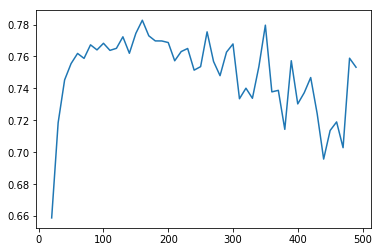

In [27]:
import matplotlib.pyplot as plt
plt.plot(tab_trail,result_acc)
plt.show()